In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, norm
from scipy.linalg import cosm, sinm

# Define Pauli matrices
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

# Define the Hamiltonian for a single qubit
H = Z

# Define the initial state
psi0 = np.array([1.0, 0.0])  # |0⟩ state

# Define the measurement operators
def measurement_operators(epsilon, H):
    M0 = (cosm(epsilon * H) - sinm(epsilon * H)) / np.sqrt(2)
    M1 = (cosm(epsilon * H) + sinm(epsilon * H)) / np.sqrt(2)
    assert np.allclose(M0.T.conj() @ M0 + M1.T.conj() @ M1, np.eye(2))
    return M0, M1

# Define the conditional unitary operator
def conditional_unitary(U_C, k0, k1, epsilon, E_th):
    x_max = 0.5 * np.arcsin((k1 - k0) / (k0 + k1))
    if x_max < epsilon * E_th:
        return np.eye(2)  # Identity matrix
    else:
        return U_C

In [6]:
def ite_algorithm(psi0, H, epsilon, E_th, num_measurements, U_C):
    psi = psi0.copy()
    k0, k1 = 0, 0
    fidelity_history = []
    x_max_history = []
    
    # Get Hamiltonian eigenvalues for reference
    E_vals = np.linalg.eigvalsh(H)
    E0, E1 = E_vals[0], E_vals[-1]  # Ground and highest excited state
    
    for t in range(num_measurements):
        M0, M1 = measurement_operators(epsilon, H)
        psi /= np.linalg.norm(psi)
        
        # Calculate probabilities
        p0 = np.vdot(psi, M0.T.conj() @ M0 @ psi).real
        p1 = np.vdot(psi, M1.T.conj() @ M1 @ psi).real
        p0, p1 = p0/(p0+p1), p1/(p0+p1)
        
        # Perform measurement
        outcome = np.random.choice([0, 1], p=[p0, p1])
        
        # Calculate hypothetical new counts
        new_k0 = k0 + (1 if outcome == 0 else 0)
        new_k1 = k1 + (1 if outcome == 1 else 0)
        
        # Calculate x_max for hypothetical state (handle division by zero)
        if (new_k0 + new_k1) > 0:
            x_max_hypothetical = 0.5 * np.arcsin((new_k1 - new_k0) / (new_k0 + new_k1))
        else:
            x_max_hypothetical = 0
        
        # Convert x_max to energy estimate: E_estimate = x_max / epsilon
        E_estimate = x_max_hypothetical / epsilon if epsilon != 0 else 0
        
        # Check threshold condition (compare energy estimate with E_th)
        if E_estimate < E_th:
            # Accept measurement: update counts and state
            k0, k1 = new_k0, new_k1
            psi = M0 @ psi if outcome == 0 else M1 @ psi
        else:
            # Reject: apply U_C and reset counts
            psi = U_C @ psi
            k0, k1 = 0, 0
        
        psi /= np.linalg.norm(psi)
        
        # Store fidelity with ground state (|1⟩ for H = Z)
        ground_state = np.array([0, 1])
        fidelity_history.append(np.abs(np.vdot(ground_state, psi))**2)
        
        # Initialize previous_x_max
        previous_x_max = 0

        # Inside the measurement loop:
        if (k0 + k1) > 0:
            current_x_max = 0.5 * np.arcsin((k1 - k0) / (k0 + k1))
            previous_x_max = current_x_max  # Store the last valid value
        else:
            current_x_max = previous_x_max  # Use last valid value when counts are zero
        x_max_history.append(current_x_max)

        #print(f"k0: {k0}, k1: {k1}, current_x_max: {current_x_max}")
    
    return fidelity_history, x_max_history

In [13]:
# Parameters
epsilon = 0.2
E_th = 0.0  # Energy threshold
num_measurements = 100
U_C = X  # Pauli-X gate as the conditional unitary

# Generate three random initial states
np.random.seed(50)  # For reproducibility
initial_states = [np.random.rand(2) for _ in range(3)]  # Three random initial states
initial_states = [state / np.linalg.norm(state) for state in initial_states]  # Normalize

# Define the |+⟩ state
plus_state = np.array([1.0, 1.0]) / np.sqrt(2)

# Run the ITE algorithm for each initial state (three random ones)
fidelity_histories = []
x_max_histories = []

for psi0 in initial_states:
    fidelity_history, x_max_history = ite_algorithm(psi0, H, epsilon, E_th, num_measurements, U_C)
    fidelity_histories.append(fidelity_history)
    x_max_histories.append(x_max_history)

# Run 1000 evolutions for the |+⟩ state and compute averages
num_plus_runs = 1000
plus_fidelity_runs = []
plus_x_max_runs = []

for _ in range(num_plus_runs):
    fidelity_history, x_max_history = ite_algorithm(plus_state, H, epsilon, E_th, num_measurements, U_C)
    plus_fidelity_runs.append(fidelity_history)
    plus_x_max_runs.append(x_max_history)

avg_plus_fidelity = np.mean(plus_fidelity_runs, axis=0)
avg_plus_x_max = np.mean(plus_x_max_runs, axis=0)



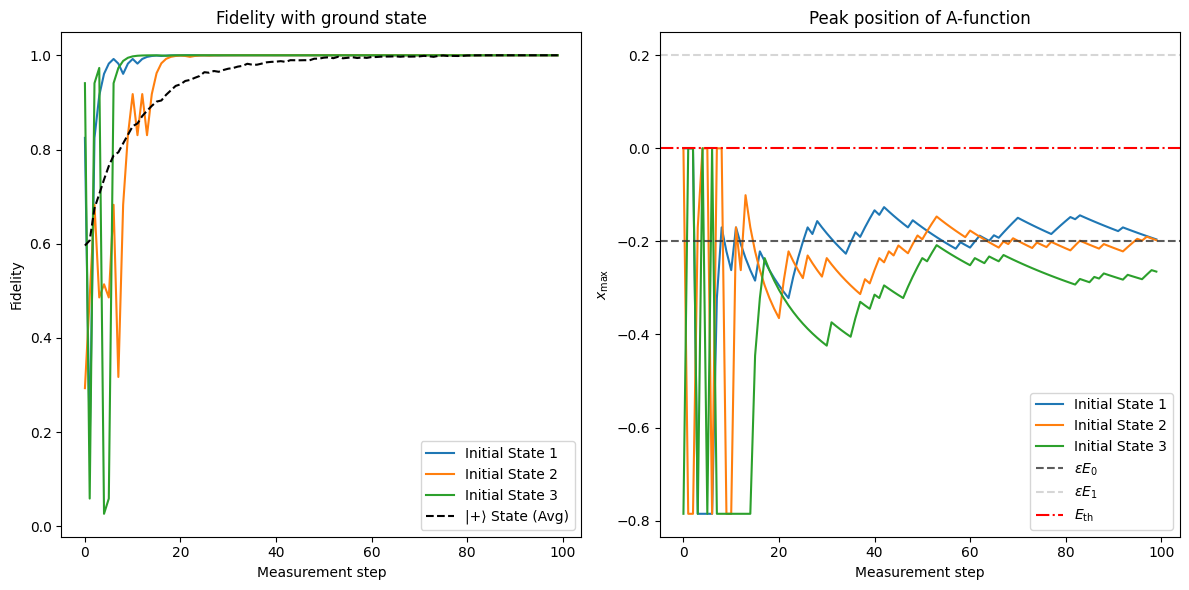

In [14]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot fidelity
plt.subplot(1, 2, 1)
for i, fidelity_history in enumerate(fidelity_histories):
    plt.plot(fidelity_history, label=f'Initial State {i+1}')
plt.plot(avg_plus_fidelity, 'k--', label='|+⟩ State (Avg)')
plt.xlabel('Measurement step')
plt.ylabel('Fidelity')
plt.title('Fidelity with ground state')
plt.legend()

# Plot x_max
plt.subplot(1, 2, 2)
for i, x_max_history in enumerate(x_max_histories):
    plt.plot(x_max_history, label=f'Initial State {i+1}')
#plt.plot(avg_plus_x_max, 'k--', label='|+⟩ State (Avg)')

# Add horizontal lines for energy eigenstates and E_th
energy_eigenvalues = np.linalg.eigvalsh(H)
epsilon_En = epsilon * energy_eigenvalues
num_eigenstates = len(epsilon_En)

for idx, En in enumerate(epsilon_En):
    gray_intensity = 0.2 + 0.6 * (idx / (num_eigenstates - 1))
    plt.axhline(En, color=(gray_intensity, gray_intensity, gray_intensity), 
                linestyle='--', alpha=0.8, label=f'$\\epsilon E_{idx}$')

plt.axhline(epsilon * E_th, color='red', linestyle='-.', label='$E_{\\text{th}}$')
plt.xlabel('Measurement step')
plt.ylabel('$x_{\\text{max}}$')
plt.title('Peak position of A-function')
plt.legend()

plt.tight_layout()
plt.show()